In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Directory containing the dataset
DATASET_DIRECTORY = 'C:/Users/EDWIN/Downloads/CICIoT2023'

# Load data with sampling for memory efficiency
df_list = []
for file in os.listdir(DATASET_DIRECTORY):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(DATASET_DIRECTORY, file))
        if len(df) > 0:
            df = df.sample(frac=0.1, random_state=42)
            df_list.append(df)

# Preprocess
combined_df = pd.concat(df_list, ignore_index=True)
X = combined_df.iloc[:, :-1].values
y = combined_df.iloc[:, -1].values

# Scale features and encode labels
scaler = StandardScaler()
label_encoder = LabelEncoder()
X = scaler.fit_transform(X).astype(np.float32)
y = label_encoder.fit_transform(y)
y_cat = to_categorical(y)

In [3]:
# Reshape the input for GRU (samples, timesteps, features)
X_reshaped = np.expand_dims(X, axis=1)  # Adding a timestep dimension


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_cat, test_size=0.2, random_state=42)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the GRU model
model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1], activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,034 (125.13 KB)

 Trainable params: 32,034 (125.13 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 381s 3ms/step - accuracy: 0.8819 - loss: 0.2934 - val_accuracy: 0.9841 - val_loss: 0.0507
Epoch 2/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 454s 4ms/step - accuracy: 0.9801 - loss: 0.0642 - val_accuracy: 0.9849 - val_loss: 0.0471
Epoch 3/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 381s 3ms/step - accuracy: 0.9818 - loss: 0.0579 - val_accuracy: 0.9853 - val_loss: 0.0458
Epoch 4/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 330s 3ms/step - accuracy: 0.9829 - loss: 0.0543 - val_accuracy: 0.9861 - val_loss: 0.0430
Epoch 5/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 340s 3ms/step - accuracy: 0.9834 - loss: 0.0524 - val_accuracy: 0.9863 - val_loss: 0.0418
Epoch 6/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 433s 4ms/step - accuracy: 0.9839 - loss: 0.0509 - val_accuracy: 0.9863 - val_loss: 0.0414
Epoch 7/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 516s 4ms/step - accuracy: 0.9843 - loss: 0.0493 - val_accuracy: 0.9863 - val_loss: 0.0412
Epoch 8/20
116717/116717 ━━━━━━━━━━━━━━━━━━━━ 52

In [7]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 98.68%


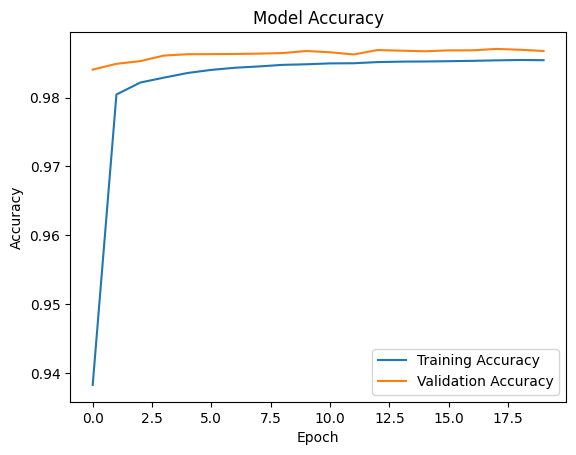

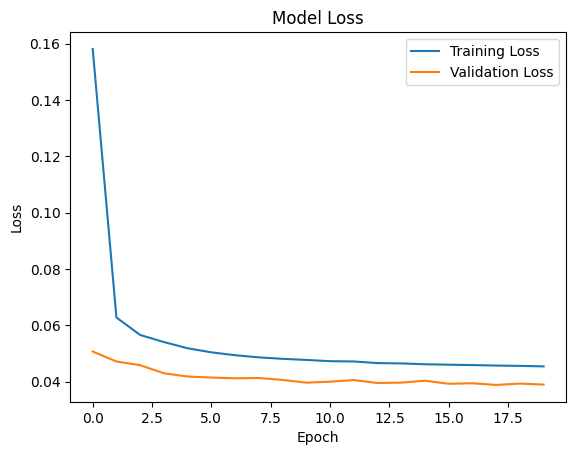

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
